In [5]:
import torch as t
import w1d4_tests
import matplotlib.pyplot as plt
import einops
import gin

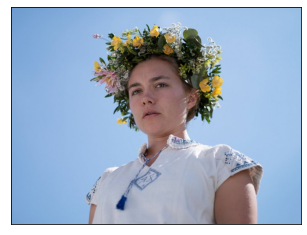

In [6]:
fname = "/home/saprmarks/Documents/hacking/MLAB/mlab-main/days/w1d4/flower_girl.jpg"
w1d4_tests.plot_image(fname)

In [7]:
data_train, data_test = w1d4_tests.load_image(fname)

In [9]:
import torch.nn as nn
import gin

@gin.configurable
class Model(nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_channels, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_channels)
        )

    def forward(self, x):
        return self.layers(x)
        

In [10]:
w1d4_tests.test_mlp(Model)

Congrats! You've passed the test.


In [6]:
def train(model, dataloader, lr, momentum):
    model.train()
    optimizer = t.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input)
        loss = nn.functional.l1_loss(output, target)
        loss.backward()
        optimizer.step()
    return model

In [7]:
w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [8]:
def evaluate(model, dataloader):
    with t.no_grad():
        loss = sum([nn.functional.l1_loss(model(input), target) for input, target in dataloader])
        return loss / len(dataloader)

In [9]:
w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


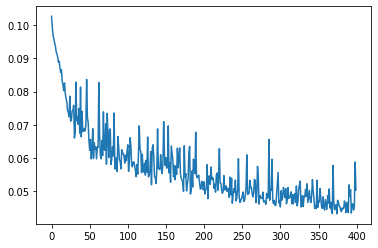

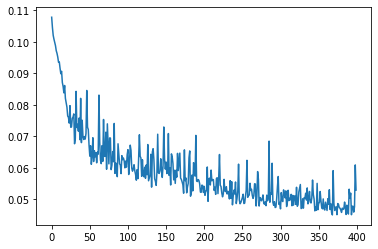

In [10]:
neurons = 400
epochs = 400

memorizer = Model(2, neurons, 3)
training_loss = []
test_loss = []
for i in range(epochs):
    train(memorizer, data_train, 0.01, 0.9)
    training_loss.append(float(evaluate(memorizer, data_train)))
    test_loss.append(float(evaluate(memorizer, data_test)))

plt.plot(range(epochs), training_loss)
plt.show()
plt.plot(range(epochs), test_loss)
plt.show()

In [11]:
from PIL import Image
d = 2
img = Image.open(fname)
W, H = img.size
x = t.linspace(-.5,.5,W//d)
y = t.linspace(-.5,.5,H//d)
pixels = t.cartesian_prod(y, x)
memorizer.eval()
pixels = memorizer(pixels) + .5
pixels = einops.rearrange(pixels, '(H W) C -> H W C', H = H//d, W = W//d, C = 3)
#print(pixels)

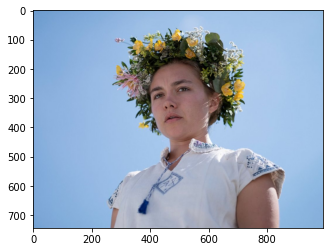

In [12]:
plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


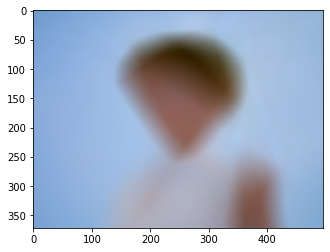

In [13]:
plt.imshow(pixels.detach().numpy())

/home/saprmarks/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


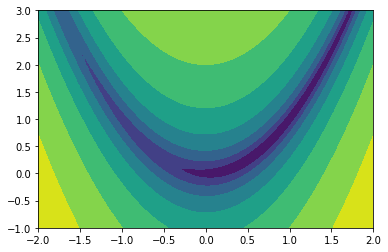

In [14]:
# plotting rosenbrock banana function
import numpy
def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2 + 1
x = t.linspace(-2, 2, 100)
y = t.linspace(-1, 3, 100)
inputs = t.meshgrid(x,y)
outputs = numpy.log(rosenbrock(*inputs))
plt.contourf(*inputs, outputs)


In [15]:
def opt_rosenbrock(xy, lr, momentum, n_iter):
    out = t.zeros([n_iter + 1, 2])
    out[0] = xy.detach()
    optimizer = t.optim.SGD((xy,), lr=lr, momentum=momentum)
    for n in range(n_iter):
        optimizer.zero_grad()
        rosenbrock(*tuple(xy)).backward()
        optimizer.step()
        out[n+1] = xy.detach()
    return out
w1d4_tests.test_rosenbrock(opt_rosenbrock)


Testing configuration:  {'lr': 0.001, 'momentum': 0.0, 'n_iter': 10}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.001, 'momentum': 0.8, 'n_iter': 20}
Congrats! You've passed the test.


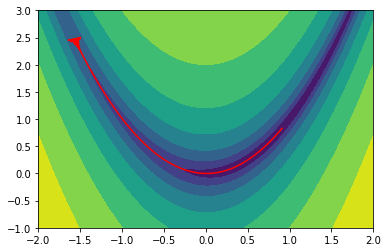

In [16]:
xy = t.tensor([-1.5,2.5], requires_grad=True)
trajectory = opt_rosenbrock(xy, .001, .8, 1000)
plt.contourf(*inputs, outputs) # plot the contour plot from above
plt.plot(trajectory[:,0], trajectory[:,1],'r') # plot the trajectory

In [26]:
@gin.register
class SGD:
    def __init__(self, params, lr, momentum=0, dampening=0, weight_decay=0):
        self.params = list(params) # save in case params is a generator
        self.lr = lr
        self.mu = momentum
        self.tau = dampening
        self.wd = weight_decay
        if self.mu != 0:
            self.b = [None for _ in self.params]
        else: self.b = None

    def zero_grad(self):
        for p in self.params:
            p.grad = None
    
    def step(self):
        with t.no_grad():
            for i, p in enumerate(self.params):
                g = p.grad + self.wd * p
                if self.mu != 0:
                    if self.b[i] is not None: 
                        g = self.mu * self.b[i] + (1 - self.tau) * g
                        self.b[i] = g
                    else: self.b[i] = g
                p -= self.lr * g

w1d4_tests.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [28]:
@gin.register
class RMSprop:
    def __init__(self, params, lr=0.01, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.wd = weight_decay
        self.mu = momentum
        self.v = [0. for _ in self.params]
        if self.mu > 0:
            self.b = [0. for _ in self.params]
        else: self.b = None

    def zero_grad(self):
        for p in self.params: p.grad = None

    def step(self):
        with t.no_grad():
            for i, p in enumerate(self.params):
                g = p.grad + self.wd * p
                self.v[i] = self.alpha * self.v[i] + (1 - self.alpha) * g * g
                if self.mu > 0:
                    self.b[i] = self.mu * self.b[i] + g / (self.v[i].sqrt() + self.eps)
                    p -= self.lr * self.b[i]
                else:
                    p -= self.lr * g / (self.v[i].sqrt() + self.eps)

w1d4_tests.test_rmsprop(RMSprop)


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [34]:
@gin.register
class Adam:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params  = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.wd = weight_decay
        self.m = [0. for _ in self.params]
        self.v = [0. for _ in self.params]
        self.t = 0

    def zero_grad(self):
        for p in self.params: p.grad = None

    def step(self):
        with t.no_grad():
            self.t += 1
            for i, p in enumerate(self.params):
                g = p.grad + self.wd * p
                self.m[i] = self.beta1 * self.m[i] + (1. - self.beta1) * g
                self.v[i] = self.beta2 * self.v[i] + (1. - self.beta2) * g**2
                m = self.m[i] / (1. - self.beta1 ** self.t)
                v = self.v[i] / (1. - self.beta2 ** self.t)
                p -= self.lr * m / (v.sqrt() + self.eps)

w1d4_tests.test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


In [38]:
import gin

@gin.configurable
def train(model, dataloader, optimizer, loss_fn, epochs):
    model.train()
    if loss_fn == "l1": lfn = nn.functional.l1_loss
    opt = optimizer(params=model.parameters())
    for _ in range(epochs):
        for input, target in dataloader:
            opt.zero_grad()
            output = model(input)
            loss = lfn(output, target)
            loss.backward()
            opt.step()
    return model

with gin.unlock_config():
    gin.parse_config_file(config_file="config.gin")
    #memorizer = Model()
    data_train, _ = w1d4_tests.load_image(fname)
    train(memorizer, data_train)



In [39]:
from PIL import Image
d = 2
img = Image.open(fname)
W, H = img.size
x = t.linspace(-.5,.5,W//d)
y = t.linspace(-.5,.5,H//d)
pixels = t.cartesian_prod(y, x)
memorizer.eval()
pixels = memorizer(pixels) + .5
pixels = einops.rearrange(pixels, '(H W) C -> H W C', H = H//d, W = W//d, C = 3)

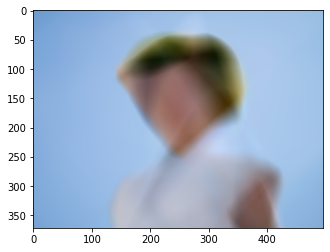

In [40]:
plt.imshow(pixels.detach())